In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

stud_math = pd.read_csv('stud_math.csv')

display(stud_math.head(10))
stud_math.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

# Функции

In [2]:
"""Функция для замены значений 'yes' и 'no' на 1 и 0 соответстенно"""

def replace_yes_no(x):
    if pd.isnull(x):
        return x
    if x == 'nan':
        return None
    x = str(x)
    x = x.replace("yes", '1')
    x = x.replace("no", '0')
    
    return int(x)

In [3]:
"""Функция для заполнения пропусков самым популярным значением в столбце"""

def nan_filling_top(column):
    column = column.apply(lambda x: 
                          int(pd.DataFrame(column.value_counts()).reset_index().head(1)['index']) if pd.isnull(x)
                          else x)
    return column

In [4]:
"""Функция для заполнения пропусков средним значением в столбце"""

def nan_filling_mean(column):
    column = column.apply(lambda x: round(column.mean(), 0) if pd.isnull(x) else x)
    return column

In [5]:
"""Функция для заполнения пропусков значением 'other'"""

def nan_filling_other(column):
    column = column.apply(lambda x: 'other' if pd.isnull(x) else x)
    return column

In [6]:
"""Функция построения гистограммы с информацией о 1 и 3 квартиле"""

def print_hist_with_quartiles(serie):
    median = serie.median()
    perc25 = serie.quantile(0.25)
    perc75 = serie.quantile(0.75)
    IQR = perc75 - perc25

    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
          , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    
    serie.hist(label = 'Все значения')
    serie.loc[serie.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(label = 'IQR')
    plt.legend()
    
    print('Выбросы')
    print(serie[serie < perc25 - 1.5*IQR])
    print(serie[serie > perc75 + 1.5*IQR])
    
    return median, perc25, perc75, IQR

# Очистка и подготовка данных

In [7]:
# Удалим колонку 'studytime, granular', которая дублирует значения колонки 'studytime'

stud_math = stud_math.drop(['studytime, granular'], axis=1)
stud_math.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      395 non-null    object 
 1   sex         395 non-null    object 
 2   age         395 non-null    int64  
 3   address     378 non-null    object 
 4   famsize     368 non-null    object 
 5   Pstatus     350 non-null    object 
 6   Medu        392 non-null    float64
 7   Fedu        371 non-null    float64
 8   Mjob        376 non-null    object 
 9   Fjob        359 non-null    object 
 10  reason      378 non-null    object 
 11  guardian    364 non-null    object 
 12  traveltime  367 non-null    float64
 13  studytime   388 non-null    float64
 14  failures    373 non-null    float64
 15  schoolsup   386 non-null    object 
 16  famsup      356 non-null    object 
 17  paid        355 non-null    object 
 18  activities  381 non-null    object 
 19  nursery     379 non-null    o

In [8]:
# В столбцах 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic' 
# заменим значения 'yes' и 'no' на 1 и 0 соответственно

for column in ('schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'):
    stud_math[column] = stud_math[column].apply(replace_yes_no)

display(stud_math.head(10))
stud_math.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,NaN,0.0,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,1.0,0.0,NaN,0.0,1.0,1.0,1.0,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      395 non-null    object 
 1   sex         395 non-null    object 
 2   age         395 non-null    int64  
 3   address     378 non-null    object 
 4   famsize     368 non-null    object 
 5   Pstatus     350 non-null    object 
 6   Medu        392 non-null    float64
 7   Fedu        371 non-null    float64
 8   Mjob        376 non-null    object 
 9   Fjob        359 non-null    object 
 10  reason      378 non-null    object 
 11  guardian    364 non-null    object 
 12  traveltime  367 non-null    float64
 13  studytime   388 non-null    float64
 14  failures    373 non-null    float64
 15  schoolsup   386 non-null    float64
 16  famsup      356 non-null    float64
 17  paid        355 non-null    float64
 18  activities  381 non-null    float64
 19  nursery     379 non-null    f

In [9]:
# Удаляем строки, в которых нет информации в колонке score
stud_math.drop(stud_math[stud_math.score.isnull()].index, inplace=True)
stud_math.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      389 non-null    object 
 1   sex         389 non-null    object 
 2   age         389 non-null    int64  
 3   address     374 non-null    object 
 4   famsize     362 non-null    object 
 5   Pstatus     344 non-null    object 
 6   Medu        386 non-null    float64
 7   Fedu        365 non-null    float64
 8   Mjob        370 non-null    object 
 9   Fjob        353 non-null    object 
 10  reason      372 non-null    object 
 11  guardian    358 non-null    object 
 12  traveltime  361 non-null    float64
 13  studytime   382 non-null    float64
 14  failures    367 non-null    float64
 15  schoolsup   380 non-null    float64
 16  famsup      351 non-null    float64
 17  paid        350 non-null    float64
 18  activities  375 non-null    float64
 19  nursery     374 non-null    f

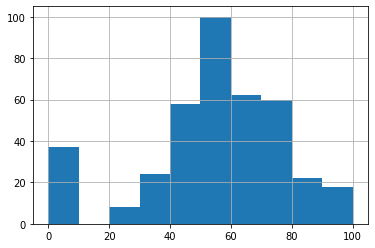

In [10]:
stud_math.score.hist()

In [11]:
# Удаляем строки, в которых score равен 0, 
# так как ближайшая оценка после 0 это 20, а дальше шаг оценки идет в 5 балоов, а значит, 0 это выброс
stud_math.drop(stud_math[stud_math.score == 0].index, inplace=True)
stud_math.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      352 non-null    object 
 1   sex         352 non-null    object 
 2   age         352 non-null    int64  
 3   address     338 non-null    object 
 4   famsize     328 non-null    object 
 5   Pstatus     311 non-null    object 
 6   Medu        350 non-null    float64
 7   Fedu        331 non-null    float64
 8   Mjob        335 non-null    object 
 9   Fjob        320 non-null    object 
 10  reason      337 non-null    object 
 11  guardian    323 non-null    object 
 12  traveltime  329 non-null    float64
 13  studytime   345 non-null    float64
 14  failures    332 non-null    float64
 15  schoolsup   343 non-null    float64
 16  famsup      316 non-null    float64
 17  paid        316 non-null    float64
 18  activities  340 non-null    float64
 19  nursery     340 non-null    f

In [12]:
# Заполним пропуски в колнке Medu самым популярным значением
stud_math.Medu = nan_filling_top(stud_math.Medu)
stud_math.Medu.value_counts()

4.0    127
2.0     88
3.0     87
1.0     47
0.0      3
Name: Medu, dtype: int64

In [13]:
# Посмотрим на значения в колонке Fedu (образование отца)
# (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
stud_math.Fedu.value_counts()

2.0     94
3.0     89
4.0     80
1.0     65
0.0      2
40.0     1
Name: Fedu, dtype: int64

In [14]:
# Скорректируем ошибочное значение "40" в колонке Fedu на "4"
stud_math.Fedu = stud_math.Fedu.apply(lambda x: 4 if x == 40 else x)
stud_math.Fedu.value_counts()

2.0    94
3.0    89
4.0    81
1.0    65
0.0     2
Name: Fedu, dtype: int64

In [15]:
# Заполним пропуски в колнке goout средним значением
stud_math.goout = nan_filling_mean(stud_math.goout)
stud_math.goout.value_counts()

3.0    124
2.0     92
4.0     74
5.0     43
1.0     19
Name: goout, dtype: int64

In [16]:
# Заполним пропуски в колнке studytime средним значением
stud_math.studytime = nan_filling_mean(stud_math.studytime)
stud_math.studytime.value_counts()

2.0    180
1.0     90
3.0     58
4.0     24
Name: studytime, dtype: int64

In [17]:
# Заполним пропуски в колнке freetime средним значением
stud_math.freetime = nan_filling_mean(stud_math.freetime)
stud_math.freetime.value_counts()

3.0    140
4.0    102
2.0     59
5.0     35
1.0     16
Name: freetime, dtype: int64

In [18]:
# Заполним пропуски в колнке schoolsup самым популярным значением
stud_math.schoolsup = nan_filling_top(stud_math.schoolsup)
stud_math.schoolsup.value_counts()

0.0    304
1.0     48
Name: schoolsup, dtype: int64

25-й перцентиль: 2.0, 75-й перцентиль: 8.0, IQR: 6.0,  Границы выбросов: [-7.0, 17.0].
Выбросы
Series([], Name: absences, dtype: float64)
40      25.0
74      54.0
89      18.0
103     26.0
118     20.0
123     18.0
183     56.0
198     24.0
203     18.0
205     28.0
216     22.0
222    385.0
234     18.0
237     20.0
260     21.0
276     75.0
277     22.0
280     30.0
281     19.0
304     20.0
307     38.0
309     18.0
311     20.0
313     22.0
315     40.0
320     23.0
390    212.0
Name: absences, dtype: float64


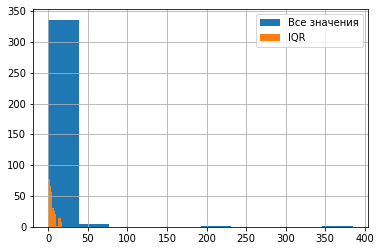

In [19]:
# Посмотрим на расрпделение значений в колнке absences (кол-во пропущенных занятий)
median, Q1, Q3, IQR = print_hist_with_quartiles(stud_math.absences)

In [20]:
# Выбросов ниже нижней границы нет
# Уменьшим количество "уникальных" значений в выбрасах выше верхней границы
# Примем за самое максимальное количество прогулов: 30, а все значения выше заменим на 30

stud_math.absences = stud_math.absences.apply(lambda x: 30 if x > 30  else x)

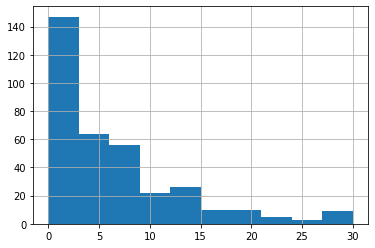

In [21]:
# Заполним пропуски в колнке absences самым популярным значением
stud_math.absences = nan_filling_top(stud_math.absences)
stud_math.absences.hist()

In [22]:
# Заполним пропуски в колнке health средним значением
stud_math.health = nan_filling_mean(stud_math.health)
stud_math.health.value_counts()

5.0    124
3.0     81
4.0     66
1.0     45
2.0     36
Name: health, dtype: int64

In [23]:
# Заполним пропуски в колнке nursery самым популярным значением
stud_math.nursery = nan_filling_top(stud_math.nursery)
stud_math.nursery.value_counts()

1.0    284
0.0     68
Name: nursery, dtype: int64

In [24]:
# Заполним пропуски в колнке higher самым популярным значением
stud_math.higher = nan_filling_top(stud_math.higher)
stud_math.higher.value_counts()

1.0    339
0.0     13
Name: higher, dtype: int64

In [25]:
# Заполним пропуски в колнке failures самым популярным значением
stud_math.failures = nan_filling_top(stud_math.failures)
stud_math.failures.value_counts()

0.0    293
1.0     38
2.0     11
3.0     10
Name: failures, dtype: int64

In [26]:
# Заполним пропуски в колнке traveltime средним значением
stud_math.traveltime = nan_filling_mean(stud_math.traveltime)
stud_math.traveltime.value_counts()

1.0    242
2.0     86
3.0     17
4.0      7
Name: traveltime, dtype: int64

In [27]:
# Посмотрим на значения в колонке famrel (семейные отношения от 1 - очень плохо до 5 - очень хорошо)
stud_math.famrel.value_counts()

 4.0    163
 5.0     88
 3.0     56
 2.0     14
 1.0      6
-1.0      1
Name: famrel, dtype: int64

In [28]:
# Заменим значение "-1" на "1", а оставшие пустые значения на среднее

stud_math.famrel = stud_math.famrel.apply(lambda x: 1 if x == -1 else x)
stud_math.famrel = nan_filling_mean(stud_math.famrel)
stud_math.famrel.value_counts()

4.0    187
5.0     88
3.0     56
2.0     14
1.0      7
Name: famrel, dtype: int64

In [29]:
# Заполним пропуски в колнке romantic самым популярным значением
stud_math.romantic = nan_filling_top(stud_math.romantic)
stud_math.romantic.value_counts()

0.0    248
1.0    104
Name: romantic, dtype: int64

In [30]:
# Заполним пропуски в колнке internet самым популярным значением
stud_math.internet = nan_filling_top(stud_math.internet)
stud_math.internet.value_counts()

1.0    303
0.0     49
Name: internet, dtype: int64

In [31]:
# Заполним пропуски в колнке Mjob значением 'other'
stud_math.Mjob = nan_filling_other(stud_math.Mjob)
stud_math.Mjob.value_counts()

other       132
services     90
teacher      51
at_home      49
health       30
Name: Mjob, dtype: int64

In [32]:
# Заполним пропуски в колнке Fjob значением 'other'
stud_math.Fjob = nan_filling_other(stud_math.Fjob)
stud_math.Fjob.value_counts()

other       208
services     89
teacher      26
health       15
at_home      14
Name: Fjob, dtype: int64

In [33]:
# Заполним пропуски в колнке reason значением 'other'
stud_math.reason = nan_filling_other(stud_math.reason)
stud_math.reason.value_counts()

course        119
reputation     96
home           89
other          48
Name: reason, dtype: int64

In [34]:
# Заполним пропуски в колнке guardian значением 'other'
stud_math.guardian = nan_filling_other(stud_math.guardian)
stud_math.guardian.value_counts()

mother    225
father     78
other      49
Name: guardian, dtype: int64

# Проанализируем полученные данные

## Проведем тест Стьюдента на полученных данных

In [52]:
def get_stat_dif(column):
    cols = stud_math.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud_math.loc[stud_math.loc[:, column] == comb[0], 'score'], 
                        stud_math.loc[stud_math.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

for col in ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian',
           'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки Fjob
Найдены статистически значимые различия для колонки schoolsup


### Вывод
Найдено несколько статистически значимых колонок для построения будущей модели.
Однако, попробуем найти больше зависимостей в представленном датасете, рассматривая детальнее группировку нескольких признаков.

## Посмотрим на оценки в зависимости от пола ученика

Статистические показатели оценки у мальчиков


count    170.000000
mean      59.470588
std       16.318275
min       25.000000
25%       50.000000
50%       60.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

Статистические показатели оценки у девочек


count    182.000000
mean      56.153846
std       15.969185
min       20.000000
25%       45.000000
50%       55.000000
75%       68.750000
max       95.000000
Name: score, dtype: float64

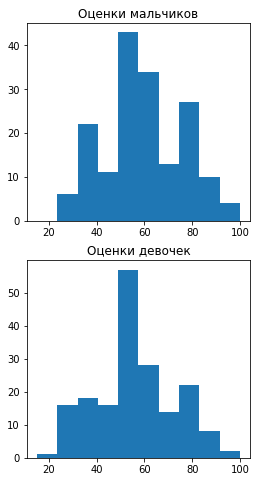

In [36]:
# Посмотрим на оценки в зависимости от пола ученика

fig, axes = plt.subplots(2, 1, figsize = (4,8))

axes[0].hist(stud_math.score[stud_math.sex == 'M'], range = (15, 100))
axes[0].set_title('Оценки мальчиков')

axes[1].hist(stud_math.score[stud_math.sex == 'F'], range = (15, 100))
axes[1].set_title('Оценки девочек')

print('Статистические показатели оценки у мальчиков')
display(stud_math[stud_math.sex == 'M'].score.describe())

print('Статистические показатели оценки у девочек')
display(stud_math[stud_math.sex == 'F'].score.describe())

### Вывод
Оценка распределена нормально как для мальчиков, так и для девочек.
У мальчиков оценка, в среднем на 5 баллов больше, чем у девочек

## Посмотрим на оценки в зависимости от школы

Статистические показатели для школы GP


count    311.000000
mean      58.215434
std       16.282245
min       20.000000
25%       47.500000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

Статистические показатели для школы MS


count    41.000000
mean     54.268293
std      15.311800
min      25.000000
25%      45.000000
50%      50.000000
75%      65.000000
max      95.000000
Name: score, dtype: float64

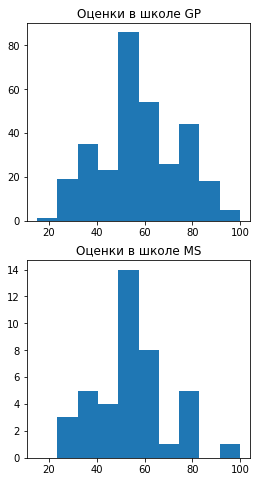

In [37]:
fig, axes = plt.subplots(2, 1, figsize = (4,8))

axes[0].hist(stud_math.score[stud_math.school == 'GP'], range = (15, 100))
axes[0].set_title('Оценки в школе GP')

axes[1].hist(stud_math.score[stud_math.school == 'MS'], range = (15, 100))
axes[1].set_title('Оценки в школе MS')

print('Статистические показатели для школы GP')
display(stud_math[stud_math.school == 'GP'].score.describe())

print('Статистические показатели для школы MS')
display(stud_math[stud_math.school == 'MS'].score.describe())

### Вывод
Средняя оценка в школе GP в среднем на 4 балла выше, но в школе MS меньше межквартильный размах.
Однако по школе MS у нас в 7,5 раз меньше данных.

## Посмотрим на зависимость между полом учеников и школой

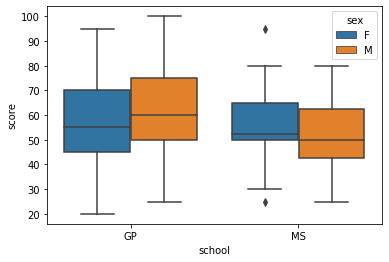

In [38]:
sns.boxplot(x = 'school', y = 'score', data = stud_math, hue = 'sex')

### Вывод
В школе GP наблюдается больший "разрыв" средних оценок между мальчиками и девочками, чем в школе MS.
При этом, в школе MS средняя оценка у девочек немного вышел.

## Посмотрим на зависимость оценки от школы и наличия доп. образовательной поддержки

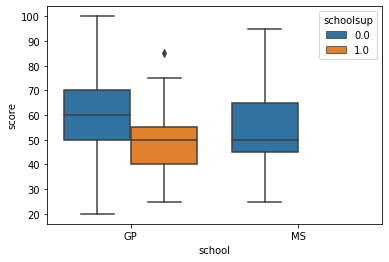

In [39]:
sns.boxplot(x = 'school', y = 'score', data = stud_math, hue = 'schoolsup')

Статистические показатели в школе GP c образовательной поддержкой


count    48.000000
mean     48.020833
std      13.035940
min      25.000000
25%      40.000000
50%      50.000000
75%      55.000000
max      85.000000
Name: score, dtype: float64

Статистические показатели в школе GP без образовательной поддержки


count    263.000000
mean      60.076046
std       16.145625
min       20.000000
25%       50.000000
50%       60.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

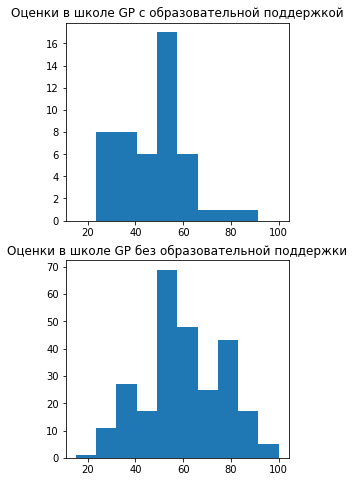

In [40]:
# Видим, что в школе "MS" вовсе нет образовательной поддержки, построим график без нее

fig, axes = plt.subplots(2, 1, figsize = (4,8))

axes[0].hist(stud_math.score[(stud_math.school == 'GP') & (stud_math.schoolsup == 1)], range = (15, 100))
axes[0].set_title('Оценки в школе GP c образовательной поддержкой')

axes[1].hist(stud_math.score[(stud_math.school == 'GP') & (stud_math.schoolsup == 0)], range = (15, 100))
axes[1].set_title('Оценки в школе GP без образовательной поддержки')

print('Статистические показатели в школе GP c образовательной поддержкой')
display(stud_math[(stud_math.school == 'GP') & (stud_math.schoolsup == 1)].score.describe())

print('Статистические показатели в школе GP без образовательной поддержки')
display(stud_math[(stud_math.school == 'GP') & (stud_math.schoolsup == 0)].score.describe())

### Вывод
У учениеков школы GP, у которых есть образовательная поддержка, средняя оценка ниже. Скорее всего, такая тенденция наблюдается из-за того, что ученикам с плохими оценками чаще нужная образовательная поддержка в школе

## Посмотрим на зависимость оценки и возраста ученика

,age,score
age,1.000000,-0.131542
score,-0.131542,1.000000


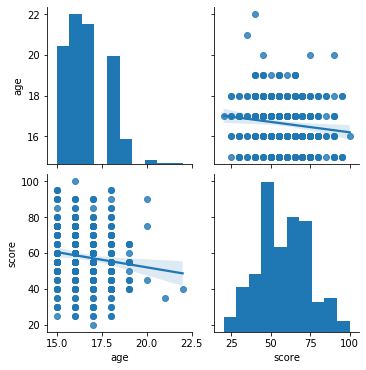

In [41]:
sns.pairplot(stud_math.loc[:, ['age','score']], kind = 'reg')
stud_math.loc[:, ['age','score']].corr()

### Предварительный вывод
Есть небольшая тенденция к снижению средней оценки с повышением возраста ученика

### Но посмотрим на связь оценки от возраста и пола ученика

Корреляция оценки от возраста для мальчиков


,age,score
age,1.000000,-0.318878
score,-0.318878,1.000000


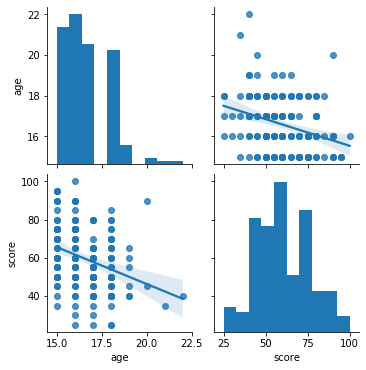

In [42]:
# Посмотрим на корреляцию оценки и возраста для мальчиков

print('Корреляция оценки от возраста для мальчиков')
sns.pairplot(stud_math[stud_math.sex == 'M'].loc[:, ['age','score']], kind = 'reg')
stud_math[stud_math.sex == 'M'].loc[:, ['age','score']].corr()

Корреляция оценки от возраста для девочек


,age,score
age,1.000000,0.076874
score,0.076874,1.000000


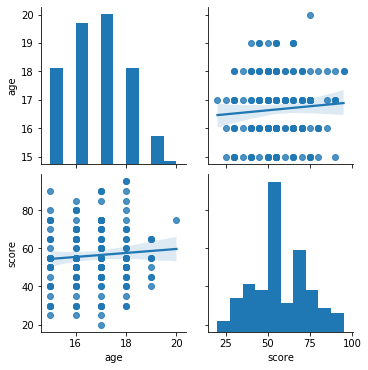

In [43]:
# Посмотрим на корреляцию оценки и возраста для девочек

print('Корреляция оценки от возраста для девочек')
sns.pairplot(stud_math[stud_math.sex == 'F'].loc[:, ['age','score']], kind = 'reg')
stud_math[stud_math.sex == 'F'].loc[:, ['age','score']].corr()

### Вывод
С возрастом, мальчики начинают учиться сильно хуже, а девочки наоборот - немного лучше

## Посмотрим на зависимость оценки от времени в пути до школы

,traveltime,score
traveltime,1.000000,-0.072435
score,-0.072435,1.000000


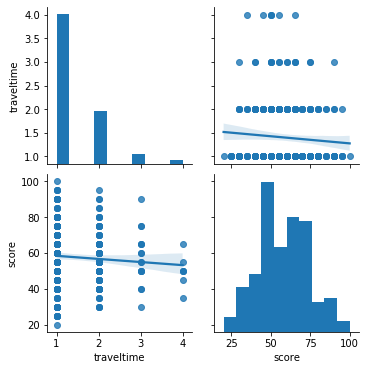

In [44]:
sns.pairplot(stud_math.loc[:, ['traveltime','score']], kind = 'reg')
stud_math.loc[:, ['traveltime','score']].corr()

### Предварительный вывод
Есть небольшая тенденция к снижению средней оценки с увеличением времени в пути до школы

,traveltime,score
traveltime,1.000000,-0.080423
score,-0.080423,1.000000


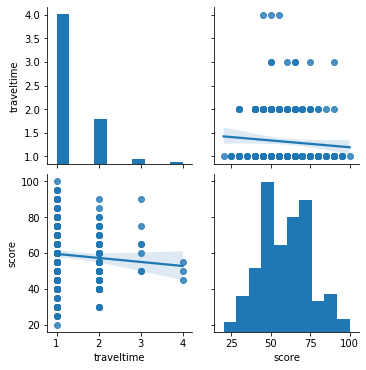

In [45]:
# Посмотрим на это же распределение, но только отдельно для городских и живущих за городом учеников
# Начнем с городских
sns.pairplot(stud_math[stud_math.address == 'U'].loc[:, ['traveltime','score']], kind = 'reg')
stud_math[stud_math.address == 'U'].loc[:, ['traveltime','score']].corr()

,traveltime,score
traveltime,1.000000,0.022688
score,0.022688,1.000000


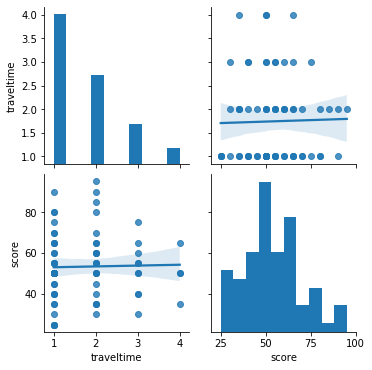

In [46]:
# А теперь для живущих за городом учеников
sns.pairplot(stud_math[stud_math.address == 'R'].loc[:, ['traveltime','score']], kind = 'reg')
stud_math[stud_math.address == 'R'].loc[:, ['traveltime','score']].corr()

### Вывод
Как мы видим, для учеников живущих за городом практически все равно, как долго им добираться до школы, этот критерий почти не вляет на их оценки. В отличии от городских, у которых наблюдается небольшое снижение среднего балла с уввеличением времени в пути до школы.

## Посмотрим на зависимость оценки от времени на учёбу помимо школы

,studytime,score
studytime,1.000000,0.139605
score,0.139605,1.000000


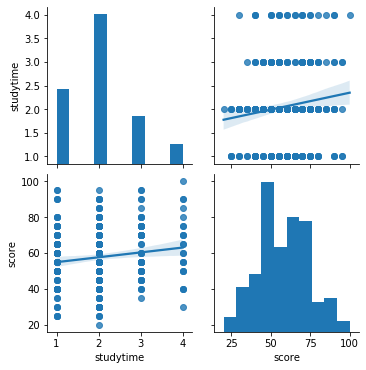

In [47]:
sns.pairplot(stud_math.loc[:, ['studytime','score']], kind = 'reg')
stud_math.loc[:, ['studytime','score']].corr()

### Вывод
Есть тенденция к увеличению средней оценки у учеников, которые много занимаются после школы

## Посмотрим на зависимость оценки от количества внеучебных неудач

,failures,score
failures,1.000000,-0.286925
score,-0.286925,1.000000


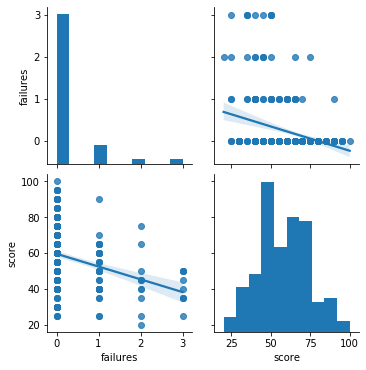

In [48]:
sns.pairplot(stud_math.loc[:, ['failures','score']], kind = 'reg')
stud_math.loc[:, ['failures','score']].corr()

### Вывод
Есть тенденция к уменьшению средней оценки у учеников, которые часто попадают в неудачные ситуации после школы

## Посмотрим на зависимость оценки от качества семейных отношений

,famrel,score
famrel,1.000000,0.017669
score,0.017669,1.000000


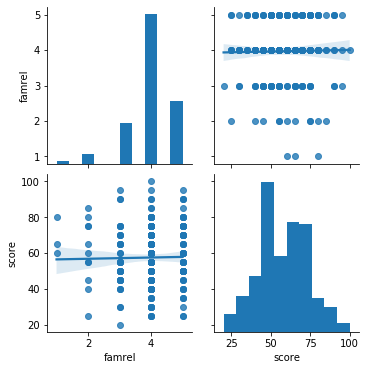

In [49]:
# Для начала посмотрим на корреляцию в семьях, в которых родители живут вместе

sns.pairplot(stud_math[stud_math.Pstatus == 'T'].loc[:, ['famrel','score']], kind = 'reg')
stud_math[stud_math.Pstatus == 'T'].loc[:, ['famrel','score']].corr()

### Предварительный вывод
В этом случае корреляции не наблюдается

,famrel,score
famrel,1.000000,0.138192
score,0.138192,1.000000


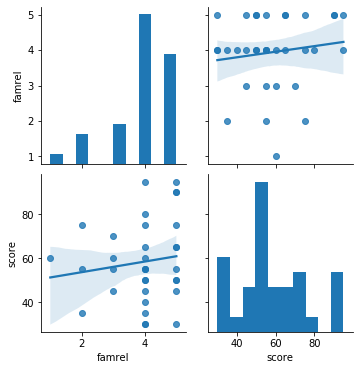

In [50]:
# А теперь посмотрим на корреляцию в семьях, в которых родители живут раздельно

sns.pairplot(stud_math[stud_math.Pstatus == 'A'].loc[:, ['famrel','score']], kind = 'reg')
stud_math[stud_math.Pstatus == 'A'].loc[:, ['famrel','score']].corr()

### Вывод
В семьях, в которых родители живут раздельно, уровень семейных отношений положительно влияет на успеваемость учеников